## ***TP 2: Anticoncepción en Indonesia***

**Preparación de los datos:**
Para poder empezar a laburar, traigo todos los paquetes que vaya a utilizar pertinentemente. Además, abro el dataset y me armo un dataframe con esos datos. Lo examino para ver qué pinta tienen.


In [ ]:
#Importo los módulos de pandas y numpy.
import pandas as pd #Para manejo de base de datos
import numpy as np #Para manejo de arrays, operaciones matemáticas, etc.
#Además, agrego otras giladas
from google.colab import drive #Para montar nuestro drive en la consola
import matplotlib.pylab as plt #Para gráficos
from sklearn.linear_model import LogisticRegression #El método de regresión logística que vamos a usar
from sklearn.metrics import confusion_matrix #Para la matriz de confusion
from sklearn.preprocessing import MinMaxScaler #Para normalizar datos
from sklearn.model_selection import train_test_split #Para dividir azarosamente los datos entre grupo de entrenamiento y grupo de testeo para cuando haga train test split
from sklearn.metrics import roc_curve #Para plantear las curvas ROC
from sklearn.metrics import roc_auc_score #Y conocer su score
from sklearn.model_selection import StratifiedKFold #Para poder hacer K folds
from sklearn.feature_selection import SelectKBest #Para poder seleccionar los k mejores features de mi modelo
from sklearn.linear_model import LogisticRegression
#Monto el drive.
from google.colab import drive
drive.mount('/content/drive')

#Defino el filename para el dataset de Anticoncepción en Indonesia.
INDO = '/content/drive/My Drive/ColabNotebooks/Entregas/anticoncepcion_indonesia.csv' 

#Cargo el dataset.
indo_data = pd.read_csv(INDO)

#Ahora si, armo el dataframe para esta encuesta de Anticoncepción en Indonesia.
indo_df = pd.DataFrame(indo_data)

#A ver qué pinta tienen estos datos...
indo_df.head()
#A ver cuántas filas tiene...
len(indo_df)

Mounted at /content/drive


296

Ok, parece que tenemos 10 columnas de información con los siguientes atributos:
1. Edad de la mujer (numérico)
2. Educación de la mujer (ordinal, 1=bajo, 2, 3, 4=alto)
3. Educación del hombre (ordinal, 1=bajo, 2, 3, 4=alto)
4. Número de hijos nacidos (numérico)
5. Religión de la mujer (binario, 1=Islam, 0= No islam)
6. ¿Trabaja la mujer? (binario, 1=Sí, 0=No)
7. Ocupación del hombre (categórico, 1,2,3,4)
8. Índice de nivel de vida (ordinal, 1=bajo, 2, 3, 4=alto)
9. Exposición a medios (binario, 1=Sí, 0=No)
10. Método anticonceptivo utilizado (categórico, 1=No usa, 2=Largo plazo, 3=Corto plazo)

Voy a querer primero eliminar toda fila que contenga algún valor Nan.

In [ ]:
#Aplico el método .dropna() para eliminar filas que tengan alguna columna con valor NaN.
#Ademas, el metodo copy() me asegura que estoy creando un nuevo dataframe. 
indo_filtrado = indo_df.dropna().copy()

Teniendo en cuenta que quiero saber si las distintas mujeres utilizan o no métodos anticonceptivos, voy a querer llevar a una categoría binaria la décima columna. Por ello, aquellas filas que indiquen usuarias de anticonceptivos de largo (2) y corto plazo (3) voy a indicarlas como usuarias de métodos anticonceptivos, colocando un 1 en la columna de AnticoncepcionSiNo que genero para dicotomizar esta variable, diferenciándolas de las que no (1), colocando un 0.
Además, voy a organizar un poquito mejor mi dataframe, eliminando la columna que categorizaba el método anticonceptivo y dejando esta nueva que generé.

In [ ]:
indo_filtrado['anticoncepcion'] = 0 #Empiezo con una columna llena de ceros. 
indice =  indo_filtrado['metodo_anticonceptivo'] > 1  # Esto me da los valores del indice para los cuales se utilizan métodos anticonceptivos de corto y largo plazo
indo_filtrado.loc[indice, 'anticoncepcion'] = 1 # Entonces para esos valores del indice pongo 1
len(indo_filtrado)
#Bueno, parece que eliminé Nan al pedo porque no habían Nan (oops)
indo_filtrado = indo_filtrado[['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos', 'religion_mujer', 'mujer_trabaja', 'ocupacion_hombre', 'nivel_vida', 'exposicion_medios', 'anticoncepcion']].copy()

Ahora sí, tengo todos los datos prolijamente ordenados.

**Test-train split:**
va a ser importante a la hora de trabajar separar parte de los datos para entrenar el modelo (obtener los parámetros) y dejar otra parte para evaluar su performance. Haciendo eso, me puedo encontrar cualquiera de los siguientes escenarios:
1. Que la performance sea baja en el set de entrenamiento y baja también en el set de evaluación. Si este es el caso, voy a estar en necesidad o bien de más datos o bien de más features.
2. Que la performance sea alta en el set de entrenamiento y baja en el set de evaluación. En este caso, estaría sobreajustando y una posible solución sería sumar más datos a mi modelo o aplicar regularización.
3. Que la performance sea alta en el set de entrenamiento y también alta en el set de evaluación. Este es el caso ideal: querría decir que aprendí parámetros que me sirven para generalizar a datos nuevos sin sobreajustar.

**Optimización de hiperparámetros: el retorno de los mejores C y potencia posibles** Necesito encontrar hiperparámetros tal que se maximice la performance del clasificador en el dataset de evaluación.
Para abordar el problema entonces haré lo siguiente:
1. Genero una función que entrene y evalúe el clasificador usando un train-test split, que incorpore como input los hiperparámetros.
2. Para cada elección del par de hiperparámetros, repitos este procedimiento unas cuantas veces y me quedo con la performance media. Esto es necesario porque el train-test split es aleatorio.
3. Repito esto para todas las combinaciones de hiperparámetros y hallo aquella que maximiza la performance del clasificador.

Introduzco dos métricas conocidas como sensibilidad y especificidad: la sensibilidad es la probabilidad de clasificar correctamente a un individuo enfermo, mientras que la especificidad es la probabilidad de que un sujeto sano tenga un resultado negativo en la prueba.
Valiéndome de ambas, introduzco la *balanced accuracy* como el promedio de estas dos métrica, un único número que resume la performance de un modelo a diferencia de la matriz de confusión que tiene 4 entradas y es un quilombo de interpretar.

In [ ]:
def balanced_accuracy(cm):
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

Ahora, mi clasificador:

In [1]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  for i in np.arange(2,n):
     X = np.concatenate((X,X**i), axis=1)
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=10000) 
  regLog.fit(X_train, y_train) 
  
  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

Calculo la performance para cada par de n y c:

In [ ]:
n_values = np.arange(1,7) # rango de potencias maximas 
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 100 

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)

[1, 0.2]


NameError: ignored

Ploteo esta información para ver cuál par de n y c mejora la performance:

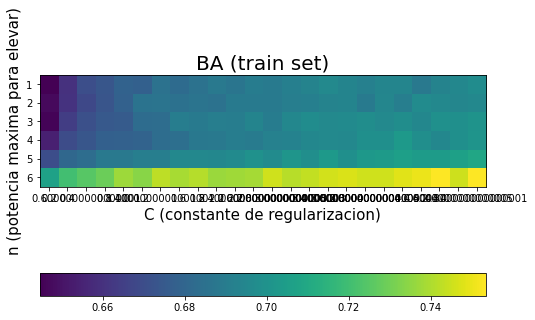

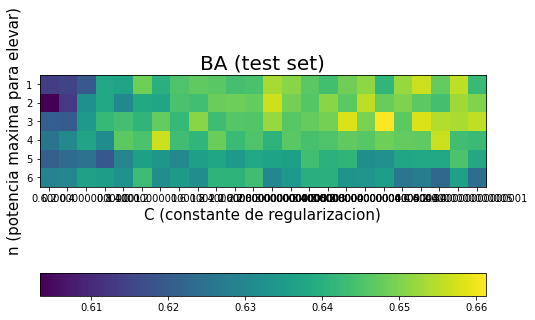

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo 
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(8,8)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)

Del gráfico de balanced accuracy para el conjunto de datos de entrenamiento veo, como es esperado, que aumenta la performance a medida que sumo potencias de grado mayor de los features. No obstante, en el caso del test set no es tan simple. Observo que se maximiza el desempeño de mi modelo cuando tengo una potencia máxima n=3 y la constante de regularizacion tiene un valor cercano a 3,6.
De ahora en más cuando haga regresión logística me va a servir usar esos dos valores pues tendré la mejor performance posible.


**¿Pero sólo un train test split?:**
Un problema del train-test split es que depende mucho de qué casos fueron a parar a cada uno de los conjuntos. Si tuve "suerte" entonces los casos del conjunto de entrenamiento serán muy informativos y el clasificador tendrá buena performance. Pero sino, no. Entonces esto fluctúa dependiendo del azar. Quizás lo mejor sea hacerlo muchas veces y luego promediar las accuracies resultantes para tener una buena idea de la performance del clasificador en ambos grupos. Pero eso es problema para después, aunque la sospecha ya está...

**Ahora sí, a modelar:**
Voy a comenzar con un modelo que incorpora features elevadas al cuadrado y al cubo para darle más flexibilidad al modelo. Calculo el AUC y ploteo la curva ROC para los datos de entrenamiento y de evaluación siguiendo un train-test split con 70-30.

AUC entrenamiento: 0.7924
AUC evaluacion: 0.6908


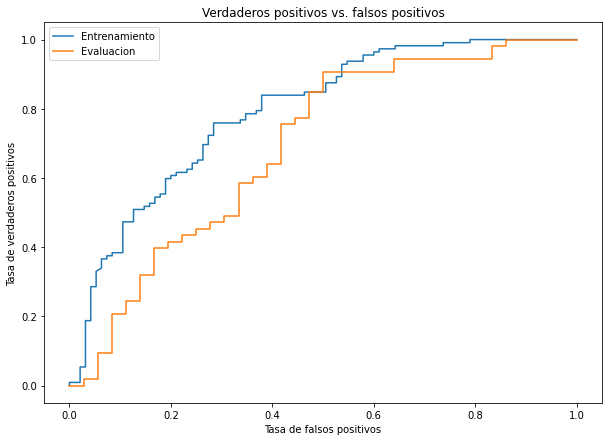

In [ ]:
#Defino la matriz X.
campos = ['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos', 'religion_mujer', 'mujer_trabaja', 'ocupacion_hombre', 'nivel_vida', 'exposicion_medios'] #Lista que contiene las features de interés.
X = indo_filtrado[campos].values #En este caso no hace falta reshapear, porque ya tiene la forma que queremos.
y = indo_filtrado['anticoncepcion'] #Mi etiqueta sigue siende la misma de antes.

X_1 = np.concatenate((X, X**2,X**3), axis=1) #Agrego features elevados a potencias 

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3) #Armo el split

scaler = MinMaxScaler() #Escaleo por separado ambos sets
scaler.fit(X_train) 
X_train = scaler.transform(X_train)

scaler = MinMaxScaler() #Escaleo por separado ambos sets
scaler.fit(X_test) 
X_test = scaler.transform(X_test)
regLog_1 = LogisticRegression(penalty='l2', C=3.6, max_iter=10000) #Inicializo nuevamente el modelo. max_iter es la cantidad de iteraciones máximas del algoritmo de optimización de parámetros antes de detenerse.
regLog_1.fit(X_train, y_train) #Ajusto el modelo con los datos de entrenamiento

probas_train = regLog_1.predict_proba(X_train)  #Probabilidades con datos de entrenamiento
probas_test = regLog_1.predict_proba(X_test)  #Probabilidades con datos de evaluación

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probas_train[:,1]) #Para plotear curva ROC con datos de entrenamiento
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) #Para plotear curva ROC con datos de evaluacion

auc_train = roc_auc_score(y_train, probas_train[:,1]) #AUC con datos de entrenamiento
auc_test = roc_auc_score(y_test, probas_test[:,1]) #AUC con datos de evaluación

#Para plotear ROC (codigo de un notebook anterior)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr_train,tpr_train, label = "Entrenamiento") # graficamos la curva ROC para el set de entrenamiento
ax.plot(fpr_test,tpr_test, label = "Evaluacion") # graficamos la curva ROC para el set de evaluacion

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

plt.legend()

print('AUC entrenamiento: {}'.format(round(auc_train,4)))  
print('AUC evaluacion: {}'.format(round(auc_test,4)))  

Como ya había advertido, si corro varias veces al bloque de código anterior, observo que hay una variabilidad natural en las curvas, aunque en general el AUC de evaluacion será menor que el de entrenamiento, debido al overfitting. 

Otro problema es que el train-test split produce predicciones no sesgadas por overfitting únicamente para los casos que fueron al test set. Si quisiera una predicción del modelo para todos los casos, entonces para aquellos en el train set obtendría una predicción más certera de lo esperable realmente.

Una forma de atenuar estos problemas es usar *validación cruzada estratificada con K folds*, la cual funciona de la siguiente manera:

1. Se dividen los datos en K subconjuntos de forma tal que la prevalencia de ambas clases esté balanceada en cada subconjunto.
2. Se elige uno de esos subconjuntos y se lo designa set de evaluación. Todos los demás son sets de entrenamiento. Se entrena entonces al modelo usando estos datos para evaluación y entrenamiento y se genera una predicción para cada uno de los datos en el conjunto que fue elegido como evaluación.
3. Se repite el proceso usando cada uno de los K subconjuntos para evaluación exactamente una vez.
De esta forma, todos los datos fueron usados una vez para evaluación y al menos una vez para entrenamiento. Además, resulta una predicción para cada uno de los casos, y esta predicción no está afectada por overfitting (porque ese caso no fue usado en entrenamiento).
Lo implemento a continuación:

In [ ]:
X_1 = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_1, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores

for train_index, test_index in skf.split(X_1, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X_1[train_index], X_1[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty='l2', C=3.6, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))
print("Estos son las probabilidades para cada sample:")
print(scores)
print("Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):")
print(indices)

Estos son los valores AUC para cada fold:
[0.7014590347923682, 0.7016317016317016, 0.7634032634032634, 0.6748251748251749, 0.6934731934731935]
Estos es el promedio de todos los AUC:
0.7069584736251404
Estos son las probabilidades para cada sample:
[0.29240135 0.77077628 0.73950122 0.78692256 0.77753809 0.0175918
 0.36278546 0.65600821 0.72618864 0.84838467 0.83898583 0.7706762
 0.83882858 0.41609695 0.78131705 0.82304262 0.74224272 0.75027299
 0.78452816 0.50199279 0.74790901 0.37637579 0.27383636 0.78306114
 0.34058599 0.53412091 0.59093347 0.85999809 0.14680368 0.31694559
 0.66249701 0.70485067 0.83589242 0.12354915 0.60502141 0.84840132
 0.78484366 0.63932928 0.20660115 0.37650133 0.61122237 0.78881898
 0.25028579 0.85861478 0.54628642 0.76725044 0.74840649 0.14577412
 0.27450895 0.15585971 0.60554525 0.85383829 0.26848995 0.14775768
 0.36815778 0.83817093 0.63893876 0.21678657 0.65567168 0.67688702
 0.86948027 0.51503114 0.44373795 0.30189906 0.58083009 0.54326512
 0.05087656 0.459

Hasta acá, mi modelo. Ahora para enviar mis predicciones valiéndome de él, primero cargo el archivo anticoncepcion_indonesia_test.csv

In [ ]:
path = '/content/drive/My Drive/ColabNotebooks/Entregas/anticoncepcion_indonesia_test.csv' 
df_test = pd.read_csv(path)
df_test.columns

Index(['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos',
       'religion_mujer', 'mujer_trabaja', 'ocupacion_hombre', 'nivel_vida',
       'exposicion_medios'],
      dtype='object')

Vemos que obviamente falta la columna que queremos predecir.

Ahora, Uds. arman la matriz de features tal como la construyeron para su modelo, incluyendo la selección que hayan armado, o el agregado de nuevos features, etc. En nuestro ejemplo es simplemente agarrar todas las columnas.

In [ ]:
campos = ['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos', 'religion_mujer', 'mujer_trabaja', 'ocupacion_hombre', 'nivel_vida', 'exposicion_medios'] #Lista que contiene las features de interés.
pipi = np.array(df_test[campos])
pipitesteo = np.concatenate((pipi, pipi**2,pipi**3), axis=1) # agrego features elevados a potencias 


Luego, predecimos las **probabilidades** (no las etiquetas binarias) usando el modelo que entrenamos.

In [ ]:
probas = regLog_1.predict_proba(pipitesteo)
print(probas)

[[0.76344697 0.23655303]
 [0.68343982 0.31656018]
 [0.51465756 0.48534244]
 ...
 [0.91764556 0.08235444]
 [0.88648577 0.11351423]
 [0.71696634 0.28303366]]


La matriz de dos columnas que obtenemos de output es lo que hay que entregar. Así que me la guardo en un drive en un archivo csv.

In [ ]:
save_path = '/content/drive/My Drive/ColabNotebooks/Entregas/Carla_Arevalo_Tp2.csv' 
np.savetxt(save_path, probas, delimiter=",")